In [1]:
import numpy as np
import pandas as pd
import sys
from itertools import groupby, combinations
from collections import Counter
from IPython.display import display


In [2]:
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj)/(1024*1024))

In [3]:
import time
start = time.process_time()
orders = pd.read_csv('market-basket-analysis/order_products__prior.csv')
print('orders -- dimensions: {0}; size:{1}'.format(orders.shape, size(orders)))
print('time taken to ingest the data:, {0:.5f}'.format(round(time.process_time() - start,5)), 'seconds')

orders -- dimensions: (32434489, 4); size:989.82 MB
time taken to ingest the data:, 7.78002 seconds


In [4]:
orders.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [5]:
orders.tail(100)

,order_id,product_id,add_to_cart_order,reordered
32434389,3421068,9175,13,0
32434390,3421068,10957,14,0
32434391,3421069,28199,1,1
32434392,3421069,9426,2,0
32434393,3421069,46667,3,1
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [6]:
orders.sample(10)

,order_id,product_id,add_to_cart_order,reordered
22128160,2333950,34459,11,0
15477178,1633128,32927,6,1
8031582,847838,23405,26,0
458948,48563,47144,4,0
9215571,972693,17956,30,0
26929378,2839566,47734,21,0
18374546,1938117,26940,7,0
26900436,2836486,5941,1,1
30213890,3187084,49683,29,0
18687445,1971217,33682,5,1


In [7]:
orders.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


In [8]:
orders = orders.set_index('order_id')['product_id']
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: product_id, dtype: int64

pandas.core.series.Series

In [9]:
orders.head()

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
Name: product_id, dtype: int64

In [10]:
orders.tail()

order_id
3421083    39678
3421083    11352
3421083     4600
3421083    24852
3421083     5020
Name: product_id, dtype: int64

In [11]:
print('dimensions: {0}; unique_orders: {1}; unique_items: {2}'.format(orders.shape, len(orders.index.unique()),len(orders.value_counts())))

dimensions: (32434489,); unique_orders: 3214874; unique_items: 49677


In [12]:
 def freq(iterable):
        if type(iterable) == pd.core.series.Series:
            return iterable.value_counts().rename("freq")
        else:
            return pd.Series(Counter(iterable)).rename('freq')
        

In [13]:
def order_count(order_item):
    return len(set(order_item.index))


In [14]:
order_count(orders)

3214874

In [15]:
item_stats = freq(orders).to_frame('freq')
item_stats['support'] = (item_stats['freq']/ order_count(orders)*100)

In [16]:
item_stats

,freq,support
24852,472565,14.699332
13176,379450,11.802951
21137,264683,8.233075
21903,241921,7.525054
47209,213584,6.643620
...,...,...
11356,1,0.000031
18001,1,0.000031
6320,1,0.000031
26268,1,0.000031


In [17]:
item_stats['support'].min()

3.110541812836211e-05

In [18]:
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
        
        for item_pair in combinations(item_list, 2):
            yield item_pair
    
min_support = 0.1
qualifying_items = item_stats[item_stats['support'] >= min_support].index
order_item = orders[orders.isin(qualifying_items)]
    

In [19]:
qualifying_items


Int64Index([24852, 13176, 21137, 21903, 47209, 47766, 47626, 16797, 26209,
            27845,
            ...
            12087,  1160, 17634,  8412, 48335, 24891, 28769, 27316,  4812,
            45290],
           dtype='int64', length=1772)

In [20]:
display("Items with support >= {}:{:15d}".format(min_support, len(qualifying_items)))
display('Remaining order_item: {:21d}'.format(len(order_item)))

'Items with support >= 0.1:           1772'

'Remaining order_item:              20726889'

In [21]:
order_size = freq(order_item.index)
qualifying_orders = order_size[order_size >=2].index
order_item = order_item[order_item.index.isin(qualifying_orders)]
type(order_item)


pandas.core.series.Series

In [22]:
order_item

order_id
2          33120
2          28985
2           9327
2          17794
3          33754
           ...  
3421082    12023
3421083    21162
3421083    18176
3421083    11352
3421083    24852
Name: product_id, Length: 20403028, dtype: int64

In [23]:
display('Remaining orders with 2+ items: {:11d}'.format(len(qualifying_orders)))
display('Remaining order_item: {:20d}'.format(len(order_item)))

'Remaining orders with 2+ items:     2732607'

'Remaining order_item:             20403028'

In [24]:
item_stats = freq(order_item).to_frame('freq')
item_stats['support'] = item_stats['freq']/ order_count(order_item)*100

In [25]:
item_stats

,freq,support
24852,464922,17.013863
13176,372600,13.635331
21137,262025,9.588829
21903,239374,8.759913
47209,211814,7.751352
...,...,...
12087,3079,0.112676
19887,3058,0.111908
9411,2927,0.107114
48142,2873,0.105138


In [26]:
order_item

order_id
2          33120
2          28985
2           9327
2          17794
3          33754
           ...  
3421082    12023
3421083    21162
3421083    18176
3421083    11352
3421083    24852
Name: product_id, Length: 20403028, dtype: int64

In [27]:
item_pair_gen = get_item_pairs(order_item)

In [28]:
# next(item_pair_gen)

In [29]:
item_pairs = freq(item_pair_gen).to_frame('freqXY')
item_pairs['supportXY'] = item_pairs['freqXY']/len(qualifying_orders)*100

In [30]:
item_pairs.head(10)

freqXY  supportXY
33120 28985     437   0.015992
      9327       39   0.001427
      17794     382   0.013979
28985 9327      151   0.005526
      17794    2847   0.104186
9327  17794      95   0.003477
33754 24838     366   0.013394
      21903    1545   0.056539
      46667     259   0.009478
      17461     117   0.004282

In [31]:
print(len(item_pairs))

2716668


In [32]:
item_pairs = item_pairs[item_pairs['supportXY'] >= min_support]

In [33]:
len(item_pairs)

1560

In [34]:
def merge_item_stats(item_pairs, item_stats):
    return(item_pairs.merge(item_stats.rename(columns={'freq': 'freqX', 'support': 'supportX'}), left_on='item_X', right_index=True).merge(item_stats.rename(columns={'freq':'freqY', 'support': 'supportY'}), left_on='item_Y', right_index=True))


In [35]:
item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_X', 'level_1': 'item_Y'})
item_pairs = merge_item_stats(item_pairs,item_stats)

In [36]:
item_pairs.head(10)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY
0,28985,17794,2847,0.104186,67117,2.456153,72459,2.651644
428,21903,17794,6641,0.243028,239374,8.759913,72459,2.651644
42,13176,17794,8688,0.317938,372600,13.635331,72459,2.651644
131,27966,17794,2953,0.108065,135995,4.976749,72459,2.651644
423,24852,17794,10709,0.391897,464922,17.013863,72459,2.651644
49,47766,17794,4731,0.173131,175462,6.421048,72459,2.651644
235,4605,17794,3241,0.118605,72747,2.662183,72459,2.651644
326,21137,17794,5572,0.203908,262025,9.588829,72459,2.651644
1172,27845,17794,3506,0.128302,135817,4.970235,72459,2.651644
429,47626,17794,3826,0.140013,151381,5.539801,72459,2.651644


In [37]:
item_pairs['confidenceXtoY'] = item_pairs['supportXY']/item_pairs['supportX']
item_pairs['confidenceYtoX'] = item_pairs['supportXY']/item_pairs['supportY']
item_pairs['lift'] = item_pairs['supportXY']/item_pairs['supportX']/item_pairs['supportY']


In [38]:
item_pairs.head(10)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift
0,28985,17794,2847,0.104186,67117,2.456153,72459,2.651644,0.042418,0.039291,0.015997
428,21903,17794,6641,0.243028,239374,8.759913,72459,2.651644,0.027743,0.091652,0.010463
42,13176,17794,8688,0.317938,372600,13.635331,72459,2.651644,0.023317,0.119902,0.008794
131,27966,17794,2953,0.108065,135995,4.976749,72459,2.651644,0.021714,0.040754,0.008189
423,24852,17794,10709,0.391897,464922,17.013863,72459,2.651644,0.023034,0.147794,0.008687
49,47766,17794,4731,0.173131,175462,6.421048,72459,2.651644,0.026963,0.065292,0.010168
235,4605,17794,3241,0.118605,72747,2.662183,72459,2.651644,0.044552,0.044729,0.016802
326,21137,17794,5572,0.203908,262025,9.588829,72459,2.651644,0.021265,0.076899,0.008020
1172,27845,17794,3506,0.128302,135817,4.970235,72459,2.651644,0.025814,0.048386,0.009735
429,47626,17794,3826,0.140013,151381,5.539801,72459,2.651644,0.025274,0.052802,0.009531


In [39]:
item_name = pd.read_csv('market-basket-analysis/products.csv')

item_name = item_name.rename(columns= {'product_id':'product_id', 'product_name': 'item_name'})


In [40]:
columns =['itemX','itemY','freqXY','supportXY','freqX', 'supportX', 'freqY', 'supportY','confidenceXtoY','confidenceYtoX','lift']
item_pair_recommendation = item_pairs.merge(item_name.rename(columns={'item_name': 'itemX'}), left_on='item_X', right_on='product_id').merge(item_name.rename(columns={'item_name':'itemY'}), left_on='item_Y', right_on='product_id')

In [41]:
item_pair_recommendation.head(100)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift,product_id_x,itemX,aisle_id_x,department_id_x,product_id_y,itemY,aisle_id_y,department_id_y
0,28985,17794,2847,0.104186,67117,2.456153,72459,2.651644,0.042418,0.039291,0.015997,28985,Michigan Organic Kale,83,4,17794,Carrots,83,4
1,21903,17794,6641,0.243028,239374,8.759913,72459,2.651644,0.027743,0.091652,0.010463,21903,Organic Baby Spinach,123,4,17794,Carrots,83,4
2,13176,17794,8688,0.317938,372600,13.635331,72459,2.651644,0.023317,0.119902,0.008794,13176,Bag of Organic Bananas,24,4,17794,Carrots,83,4
3,27966,17794,2953,0.108065,135995,4.976749,72459,2.651644,0.021714,0.040754,0.008189,27966,Organic Raspberries,123,4,17794,Carrots,83,4
4,24852,17794,10709,0.391897,464922,17.013863,72459,2.651644,0.023034,0.147794,0.008687,24852,Banana,24,4,17794,Carrots,83,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,47209,47626,9057,0.331442,211814,7.751352,151381,5.539801,0.042759,0.059829,0.007719,47209,Organic Hass Avocado,24,4,47626,Large Lemon,24,4
96,24964,47626,7098,0.259752,109310,4.000209,151381,5.539801,0.064935,0.046888,0.011721,24964,Organic Garlic,83,4,47626,Large Lemon,24,4
97,26209,47626,12030,0.440239,139595,5.108492,151381,5.539801,0.086178,0.079468,0.015556,26209,Limes,24,4,47626,Large Lemon,24,4
98,45007,47626,5115,0.187184,104325,3.817783,151381,5.539801,0.049029,0.033789,0.008850,45007,Organic Zucchini,83,4,47626,Large Lemon,24,4


In [58]:
item_pair_name=item_pair_recommendation[['itemX', 'itemY', 'freqXY','lift']].sort_values('lift',ascending=False)

In [59]:
item_pair_name.head(20)

,itemX,itemY,freqXY,lift
1559,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,3802,0.331422
1508,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,3422,0.298297
1507,Vanilla Skyr Nonfat Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,3483,0.274329
1549,Icelandic Style Skyr Blueberry Non-fat Yogurt,Vanilla Skyr Nonfat Yogurt,3170,0.249676
1526,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt With Blu...,5575,0.247471
1542,Total 2% Lowfat Greek Strained Yogurt With Blu...,Total 2% Lowfat Greek Strained Yogurt with Peach,3359,0.223792
1541,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt with Peach,4718,0.218266
1536,Total 2% Lowfat Greek Strained Yogurt With Blu...,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,2778,0.204470
1527,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% Lowfat Greek Strained Yogurt With Blu...,2923,0.194743
1535,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,3311,0.169220


In [44]:
str(item_pair_name['itemY'])[:-42]

'188                                                Banana\n25                                 Bag of Organic Bananas\n189                                                Banana\n171                                                Banana\n177                                                Banana\n                              ...                        \n1526    Total 2% Lowfat Greek Strained Yogurt With Blu...\n1549                           Vanilla Skyr Nonfat Yogurt\n1507        Icelandic Style Skyr Blueberry Non-fat Yogurt\n1508        Icelandic Style Skyr Blueberry Non-fat Yogurt\n1559                             Non Fat Raspberry Yogur'

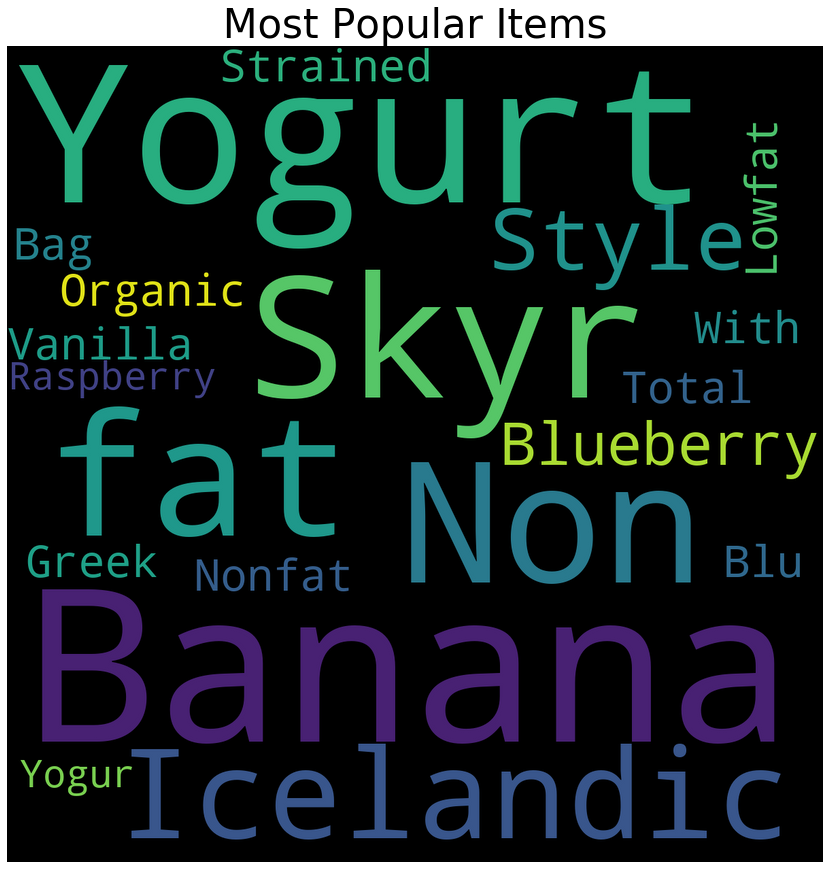

In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'black', width = 1200,  height = 1200, max_words = 121).generate(str(item_pair_name['itemY'])[:-42])
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis('off')
plt.title('Most Popular Items',fontsize = 40)
plt.show()

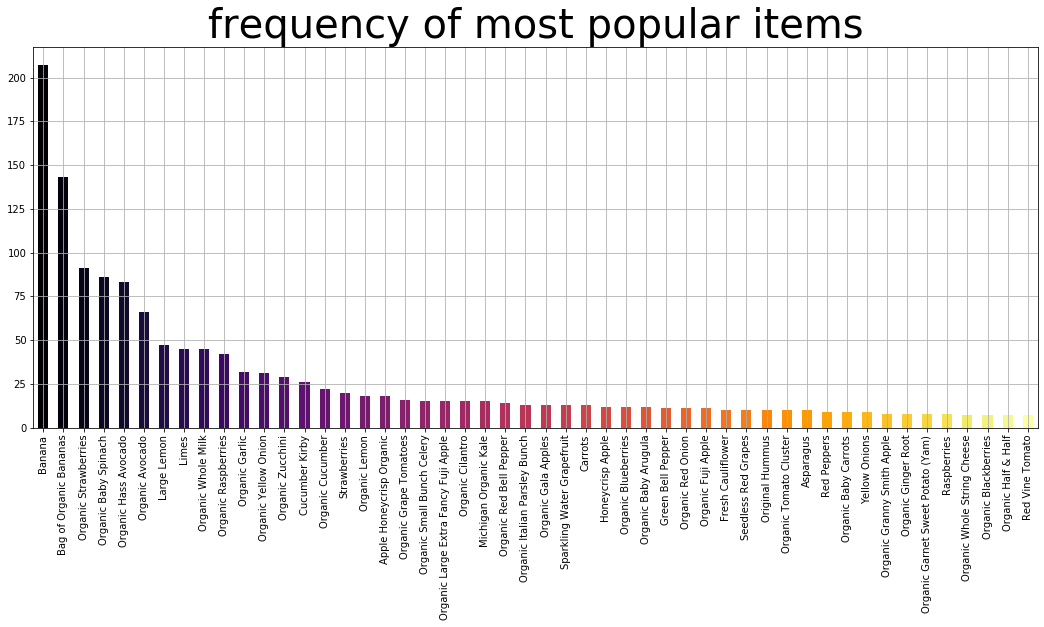

In [46]:

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.inferno(np.linspace(0, 1, 50))
item_pair_recommendation['itemX'].value_counts().head(50).plot.bar(color = color)
plt.title('frequency of most popular items', fontsize = 40)
plt.grid()
plt.show()

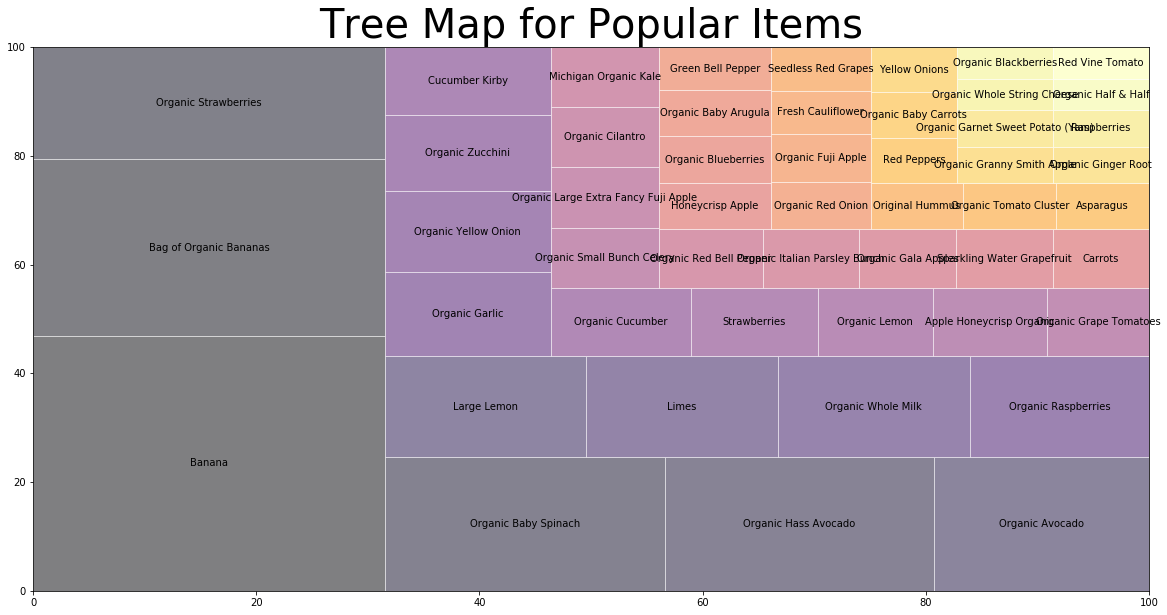

In [47]:
import squarify

y = item_pair_recommendation['itemX'].value_counts().head(50)

plt.rcParams['figure.figsize'] = (20, 10)
color = plt.cm.inferno(np.linspace(0, 1, 50))
squarify.plot( sizes = y.values, label = y.index, alpha=.5, color = color, bar_kwargs=dict(linewidth=1, edgecolor="white"), text_kwargs={'fontsize':10})
plt.title('Tree Map for Popular Items', fontsize = 40)
plt.axis('on')
plt.show()

In [48]:
y

Banana                                  207
Bag of Organic Bananas                  143
Organic Strawberries                     91
Organic Baby Spinach                     86
Organic Hass Avocado                     83
Organic Avocado                          66
Large Lemon                              47
Limes                                    45
Organic Whole Milk                       45
Organic Raspberries                      42
Organic Garlic                           32
Organic Yellow Onion                     31
Organic Zucchini                         29
Cucumber Kirby                           26
Organic Cucumber                         22
Strawberries                             20
Organic Lemon                            18
Apple Honeycrisp Organic                 18
Organic Grape Tomatoes                   16
Organic Small Bunch Celery               15
Organic Large Extra Fancy Fuji Apple     15
Organic Cilantro                         15
Michigan Organic Kale           

In [49]:
recommended = item_pair_name[item_pair_name['itemX'] == 'Banana'].head(5)

In [50]:
recommended['itemY']

1441                       Spring Water
1287                      Hass Avocados
840                       Organic Lemon
1436    Sparkling Natural Mineral Water
1320                Large Alfresco Eggs
Name: itemY, dtype: object

In [51]:
item_pair_name[item_pair_name['itemX']=='Bartlett Pears'].sort_values('lift',ascending=False).head(5)

,itemX,itemY,freqXY,lift
236,Bartlett Pears,Banana,3182,0.00532


In [52]:
def recommend_user(cart_items):
    final_recommendation = pd.DataFrame(columns=['itemY', 'lift'])
    for item in cart_items:
        pre_recommendations = item_pair_name[item_pair_name['itemX']==item].sort_values('lift',ascending=False).head(5)
        for items in pre_recommendations.itertuples():
            y= str(items.itemY)
            if y not in cart_items:
                final_recommendation= final_recommendation.append({'itemY':items.itemY, 'lift': items.lift}, ignore_index=True)
    return(final_recommendation.sort_values('lift',ascending=False))
        
    

In [62]:
list_of_items = ['Bag of Organic Bananas','Gala Apples','Icelandic Style Skyr Blueberry Non-fat Yogurt']
result =recommend_user(list_of_items).head(10)

In [63]:
display(result)

,itemY,lift
5,Non Fat Raspberry Yogurt,0.331422
6,Vanilla Skyr Nonfat Yogurt,0.249676
0,Organic Navel Orange,0.017763
1,Organic Bosc Pear,0.016864
2,Organic D'Anjou Pears,0.016606
3,Organic Thompson Seedless Raisins,0.016376
4,Organic Large Extra Fancy Fuji Apple,0.015685


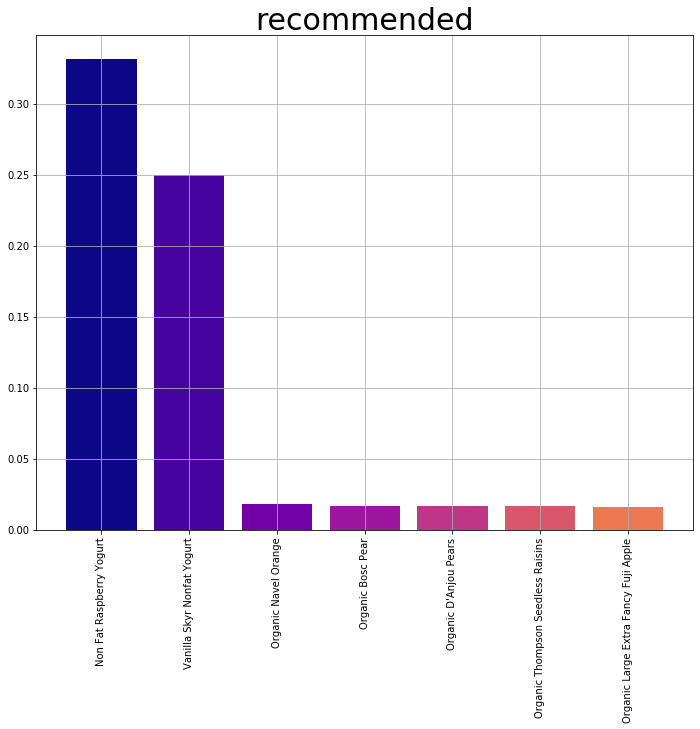

In [64]:

plt.rcParams['figure.figsize'] = (40,20)
color = plt.cm.plasma(np.linspace(0, 1, 10))
plt.subplot(232)
plt.bar(result['itemY'], result['lift'], color = color)
plt.title('recommended', fontsize = 30)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

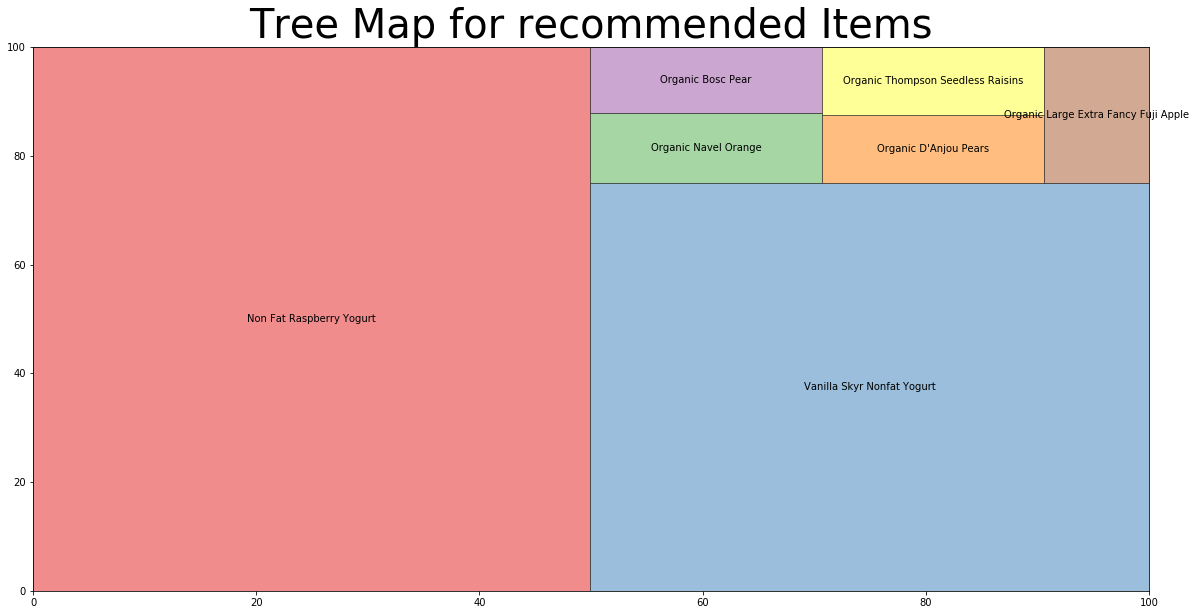

In [65]:
data= result[result['lift']>=0]
y = result['itemY'].value_counts().head(50).to_frame()
# y.index
plt.rcParams['figure.figsize'] = (20, 10)
color = plt.cm.Set1(np.linspace(0, 1, 10))
squarify.plot( sizes = data.lift, label = data.itemY, alpha=.5, color = color, bar_kwargs=dict(linewidth=1, edgecolor="#222222"), text_kwargs={'fontsize':10})
plt.title('Tree Map for recommended Items', fontsize = 40)
plt.axis('on')
plt.show()

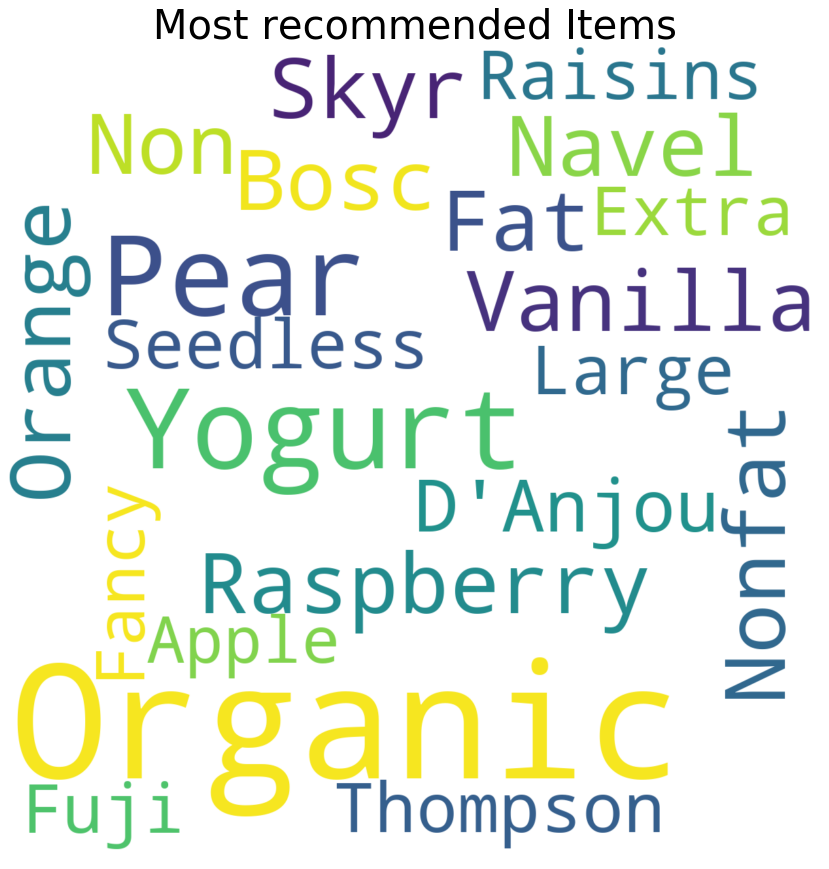

In [66]:

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(result['itemY'])[:-26])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most recommended Items',fontsize = 40)
plt.show()